## Procedure for fitting the model to IB data

For this procedure we simulate the model for many combinations of the parameters and find the one that best matches the observed data. 

### Epidemiological data

Time series available are

* Deaths (official data)
* Deaths (press data)
* UCI patients
* Recovered patients
* Infected patients
* Hospitalized patients

### Results of the model

Time series from the model

* Infected
* Recovered

### Fitting model to data

In order to fit the model to the data we proceed in the following way for each combination of parameters:

1. Fix a proportion of recovered patients that actually die. ($\mu_D$)
2. Shift rescaled curve of recovered patients by tau from the model to best fit the curve of deaths from the data. The best fit is assessed by a $\chi^2$ function.
3. With that tau move also the curve of infected from the model and rescale it to best match the curve of UCI patients. Best value of this variable also given by Chi squared. ($\mu_{UCI}$)
4. Assign to this set of parameters the $\chi^2$ that is the sum of the ones in 2. and 3. and save it together with the parameter values, the proportion of deaths and the obtained parameters tau and proportion of infected in UCI.

From all the $\chi^2$ values choose the one that is minimum.

In [1]:
import fit_functions as ff
#Parameters of the fitting procedure:
chi2_type = 'log'
minvalue = 10
weight = 0.5
percents = [0.01, 0.006, 0.034]
Ndays = [40, 55]
predict = False

#Fitting:
f, day_sh, mu_U = ff.complete_fit(chi2_type = chi2_type,
                                  minvalue = minvalue,
                                  weight = weight,
                                  percents = percents,
                                  Ndays = Ndays)

0.01 77
0.01 76
0.01 75
0.01 74
0.01 73
0.01 72
0.01 71
0.01 70
0.01 69
0.01 68
0.01 67
0.01 66
0.01 65
0.01 64
0.01 63
0.01 62
0.01 61
0.01 60
0.01 59
0.01 58
0.01 57
0.01 56
0.01 55
0.01 54
0.01 53
0.01 52
0.01 51
0.01 50
0.01 49
0.01 48
0.01 47
0.01 46
0.01 45
0.01 44
0.01 43
0.01 42
0.01 41
0.01 40
0.01 39
0.01 38
0.01 37
0.01 36
0.01 35
0.01 34
0.01 33
0.01 32
0.01 31
0.01 30
0.01 29
0.01 28
0.01 27
0.01 26
0.01 25
0.01 24
0.01 23
0.01 22
0.01 21
0.01 20
0.01 19
0.01 18
0.01 17
0.01 16
0.01 15
0.01 14
0.01 13
0.01 12
0.01 11
0.01 10
0.01 9
0.01 8
0.01 7
0.01 6
0.01 5
0.01 4
0.01 3
0.01 2
0.01 1
0.01 1008.4411627449999 ../results/time_av_4_20_0.15.dat 53 0.0012000000000000001
0.006 77
0.006 76
0.006 75
0.006 74
0.006 73
0.006 72
0.006 71
0.006 70
0.006 69
0.006 68
0.006 67
0.006 66
0.006 65
0.006 64
0.006 63
0.006 62
0.006 61
0.006 60
0.006 59
0.006 58
0.006 57
0.006 56
0.006 55
0.006 54
0.006 53
0.006 52
0.006 51
0.006 50
0.006 49
0.006 48
0.006 47
0.006 46
0.006 45
0.006 44
0.006

In [2]:
df_params = ff.params_to_df(percents, f, day_sh, mu_U)
df_params

,mu_D,T_e,T_i,beta,mu_U,dayshift
0,0.010,4,20,0.15,0.00120,53
1,0.006,3,20,0.15,0.00071,50
2,0.034,5,20,0.15,0.00479,50


/home/juanf/anaconda2/envs/mantas/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


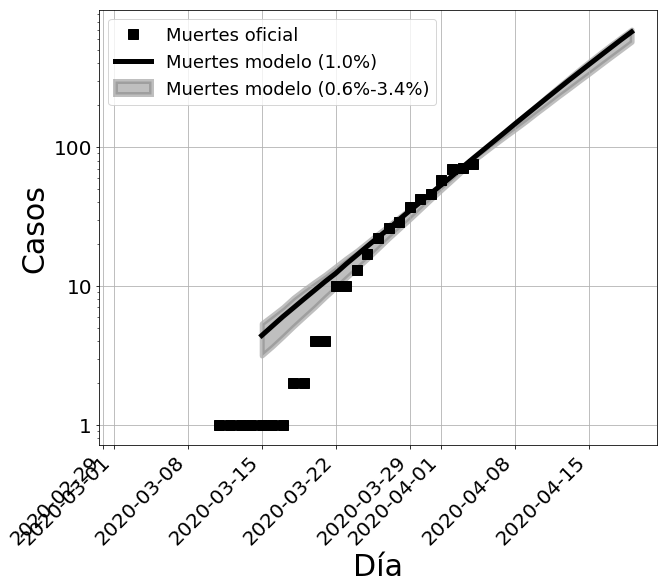

In [3]:
#Plotting:
x_M, y_M, x2, y2, y2m, y2M = ff.plot_deaths(percents,
                                            f,
                                            day_sh,
                                            mu_U,
                                            chi2_type = chi2_type,
                                            minvalue = minvalue,
                                            predict = False)


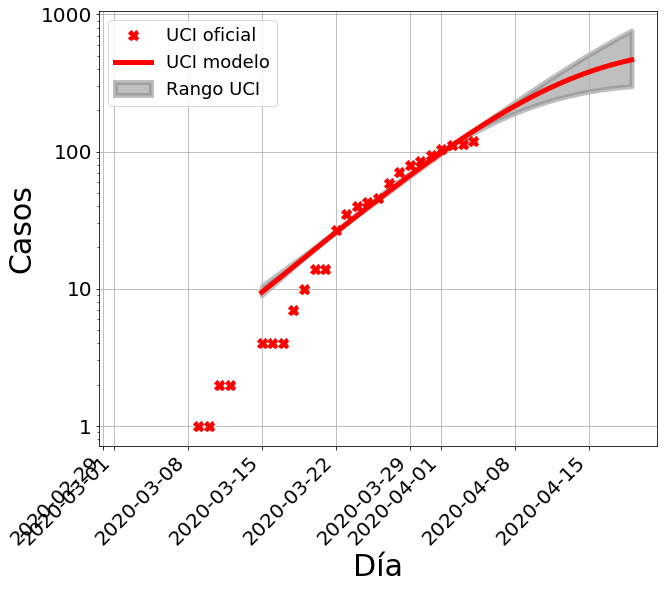

In [4]:
x_M, y_M, x2, y2, y2m, y2M = ff.plot_UCI(percents,
                                         f,
                                         day_sh,
                                         mu_U,
                                         chi2_type = chi2_type,
                                         minvalue = minvalue,
                                         predict = False)